In [6]:
#!/usr/bin/python
# this is the example script to use xgboost to train
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('output2_gg.csv', delimiter=';')
print ('finish loading from csv ')
print('Size of data: {}'.format(data.shape))
print('Number of events: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))
print ('\nList of features in dataset:')
for col in data.columns:
   print(col)

finish loading from csv 
Size of data: (773417, 58)
Number of events: 773417
Number of columns: 58

List of features in dataset:
year
e_met_mT_per_M
m_met_mT_per_M
mPt_Per_e_m_Mass
ePt_Per_e_m_Mass
e_m_Mass
emPt
emEta
mEta
eEta
j1Pt
j2Pt
j1Eta
j2Eta
DeltaEta_e_m
DeltaPhi_e_m
DeltaEta_e_j1
DeltaPhi_e_j1
DeltaEta_m_j1
DeltaPhi_m_j1
DeltaEta_e_j2
DeltaPhi_e_j2
DeltaEta_m_j2
DeltaPhi_m_j2
DeltaEta_em_j1
DeltaPhi_em_j1
DeltaEta_em_j2
DeltaPhi_em_j2
DeltaEta_j1_j2
DeltaPhi_j1_j2
Zeppenfeld
Zeppenfeld_ver2
Zeppenfeld_ver3
j1_j2_mass
DeltaPhi_em_j1j2
DeltaEta_em_j1j2
m_met_mT
e_met_mT
DeltaPhi_e_met
DeltaPhi_m_met
MetEt
e_m_PZeta
R_pT
pT_cen
pT_cen_ver2
pT_cen_ver3
cen
DeltaR_e_m
weight
DeltaR_em_j1
DeltaR_em_j2
DeltaR_j1_j2
DeltaR_em_j1j2
DeltaR_e_j1
DeltaR_m_j1
DeltaR_e_j2
DeltaR_m_j2
label


In [81]:
data['label'] = data.label.astype('category')
feature_names = ['e_met_mT_per_M', 'm_met_mT_per_M', 'mPt_Per_e_m_Mass', 'ePt_Per_e_m_Mass', 'emEta', 'DeltaR_e_m', 'MetEt', 'j1Pt', 'DeltaR_em_j1', 'j1Eta', 'j2Pt', 'DeltaR_em_j2', 'j2Eta', 'DeltaEta_j1_j2', 'R_pT']

# split data into X and y
X = data
Y = data['label']

# split data into train and test sets
seed = 123
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [114]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import multiprocessing
nthreads = multiprocessing.cpu_count()-1
model = xgb.XGBClassifier(n_jobs=nthreads)
random_search=RandomizedSearchCV(model,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=nthreads,cv=5,verbose=3)
from datetime import timedelta
tic = time.time()
random_search.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'], eval_metric='auc')
toc = time.time()
print "Time spent on hyperparameter optimization %s"%str(timedelta(seconds=toc - tic))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=23)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=23)]: Done   7 out of  25 | elapsed:  5.0min remaining: 12.9min
[Parallel(n_jobs=23)]: Done  16 out of  25 | elapsed:  7.2min remaining:  4.1min
[Parallel(n_jobs=23)]: Done  25 out of  25 | elapsed:  9.1min remaining:    0.0s
[Parallel(n_jobs=23)]: Done  25 out of  25 | elapsed:  9.1min finished


Time spent on hyperparameter optimization 0:09:49.325225


In [120]:
random_search.cv_results_

{'mean_fit_time': array([152.82703085, 391.73801155, 452.75329766, 153.90536542,
        186.30075154]),
 'mean_score_time': array([1.17819571, 0.70627384, 0.35088811, 1.04451804, 0.76803594]),
 'mean_test_score': array([0.93024376, 0.92903097, 0.92824979, 0.92575711, 0.92803799]),
 'mean_train_score': array([0.93230556, 0.9320088 , 0.93008831, 0.92629073, 0.92900171]),
 'param_colsample_bytree': masked_array(data=[0.5, 0.3, 0.7, 0.5, 0.5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.0, 0.4, 0.1, 0.3, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.25, 0.3, 0.05, 0.15, 0.15],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 10, 12, 3, 4],
              mask=[False, False, False,

In [119]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.0, learning_rate=0.25,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=23, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [131]:
# fit model no training data
tic = time.time()
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.1, learning_rate=0.15,
       max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
       n_estimators=100, n_jobs=23, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
model.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'], eval_set = [(X_train[feature_names], y_train), (X_test[feature_names], y_test)], eval_metric='auc', verbose=False)
toc = time.time()
print "Time spent on training %s"%str(timedelta(seconds=toc - tic))

Time spent on training 0:00:40.133094


AUC of training set: 0.929337
AUC of testing set: 0.927819


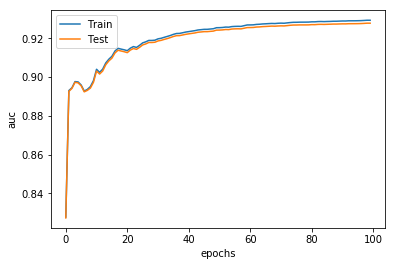

In [162]:
results = model.evals_result()
print "AUC of training set: %f"%results['validation_0']['auc'][-1]
print "AUC of testing set: %f"%results['validation_1']['auc'][-1]
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.xlabel('epochs')
plt.show()
# train = xgb.DMatrix(data=X_train[feature_names],label=X_train.label.cat.codes,
#                    feature_names=feature_names, weight=X_train['weight'])
# test = xgb.DMatrix(data=X_test[feature_names],label=X_test.label.cat.codes,
#                    feature_names=feature_names, weight=X_test['weight'])
# booster = model.get_booster()
# print(booster.eval(test))
# print(booster.eval(train))
predictions_sig_test = model.predict_proba(X_test.loc[X_test['label'] == 1][feature_names])
predictions_bkg_test = model.predict_proba(X_test.loc[X_test['label'] == 0][feature_names])

predictions_sig_train = model.predict_proba(X_train.loc[X_train['label'] == 1][feature_names])
predictions_bkg_train = model.predict_proba(X_train.loc[X_train['label'] == 0][feature_names])

# sklearn auc does not work on negative weights
# y_pred = model.predict_proba(X_test[feature_names])
# print roc_auc_score(y_test, y_pred[:,1], sample_weight=X_test['weight'], pos_label = 1)

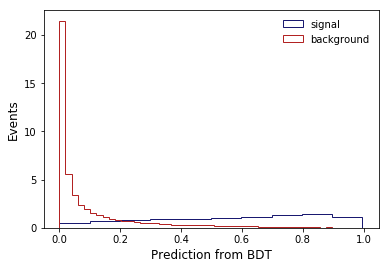

In [163]:
# plot signal and background separately
plt.figure();
plt.hist(predictions_sig_test[:,1],density=True,
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions_bkg_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


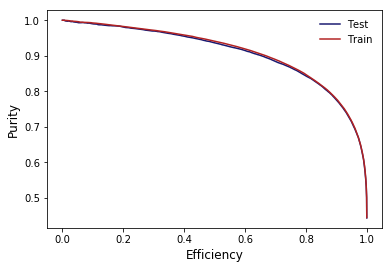

In [171]:
cuts = np.linspace(0,1,500);
#testing set
nsignal_test = np.zeros(len(cuts));
nbackground_test = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal_test[i] = len(np.where(predictions_sig_test[:,1] > cut)[0]);
    nbackground_test[i] = len(np.where(predictions_bkg_test[:,1] > cut)[0]);
#training set
nsignal_train = np.zeros(len(cuts));
nbackground_train = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal_train[i] = len(np.where(predictions_sig_train[:,1] > cut)[0]);
    nbackground_train[i] = len(np.where(predictions_bkg_train[:,1] > cut)[0]);
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal_test/len(X_test[X_test.label == 1]),nsignal_test/(nsignal_test + nbackground_test),'-',color='midnightblue', label='Test');
plt.plot(nsignal_train/len(X_train[X_train.label == 1]),nsignal_train/(nsignal_train + nbackground_train),'-',color='firebrick', label='Train');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);